In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
#seaborn styling
sns.set(style="whitegrid")

import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

import warnings
warnings.filterwarnings("ignore")

In [27]:
dft = pd.read_csv("df_6cat.csv", low_memory=False)
dft.ds = pd.to_datetime(df.ds)
dft.set_index("ds",inplace=True)

In [29]:
dft["day"] = dft.index.strftime("%w %a")
dft["year"] = dft.index.strftime("%Y")
dft["month"] = dft.index.strftime("%m %B")

---

# I. What's the overall state of the business from 2015-2019?

In [35]:
ypy = pd.pivot_table(dft,values="acn",index="category",columns="year",aggfunc=np.sum)

ypy["15-16 %"] = round(((ypy['2016'] - ypy['2015'])/ypy['2015'])*100,2)
ypy["16-17 %"] = round(((ypy["2017"] - ypy["2016"])/ypy["2016"])*100,2)
ypy["17-18 %"] = round(((ypy["2018"] - ypy["2017"])/ypy["2017"])*100,2)
ypy["18-19 %"] = round(((ypy["2019"] - ypy["2018"])/ypy["2018"])*100,2)

ypy = ypy.reset_index().rename(columns={"year":"index"})

## EARNINGS: Year-Per-Year Percentage Change

In [36]:
ypy

year  category     2015     2016      2017      2018      2019  15-16 %  \
0        Admin  1168391  2475154   4444823  10405779  15446194   111.84   
1          Bar  7018302  8154985  11916298  26460220  42466516    16.20   
2        Event   446221   742488    984688   1057215   2323802    66.39   
3      Fitness  1155049  1408091   1789445   1988874   3750184    21.91   
4     Pro Shop   937059  1169382   1243899   1736427   2044132    24.79   
5       Tennis  3074119  4677493   5300852   6650031   9597499    52.16   

year  16-17 %  17-18 %  18-19 %  
0       79.58   134.11    48.44  
1       46.12   122.05    60.49  
2       32.62     7.37   119.80  
3       27.08    11.14    88.56  
4        6.37    39.60    17.72  
5       13.33    25.45    44.32

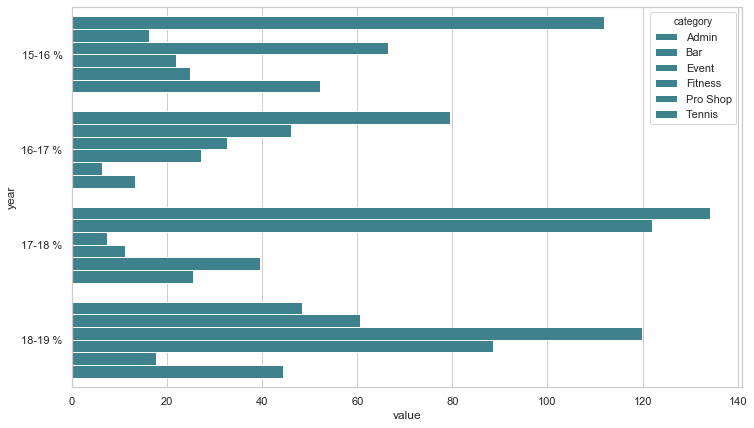

In [47]:
ypy_melt = ypy.melt(id_vars="category",var_name="year")

plt.figure(figsize=(12,7))
sns.barplot(x="value", y="year", hue="category",data=ypy_melt[ypy_melt.year.isin(["15-16 %","16-17 %","17-18 %","18-19 %"])],palette=["#328B9B"])

## FINDING: All positive change. Every year in every product line, there's increase in sales.

In [38]:
ypy_eng = pd.pivot_table(dft,values="acn",index="category",columns="year",aggfunc="count")

ypy_eng["15-16 %"] = round(((ypy_eng['2016'] - ypy_eng['2015'])/ypy_eng['2015'])*100,2)
ypy_eng["16-17 %"] = round(((ypy_eng["2017"] - ypy_eng["2016"])/ypy_eng["2016"])*100,2)
ypy_eng["17-18 %"] = round(((ypy_eng["2018"] - ypy_eng["2017"])/ypy_eng["2017"])*100,2)
ypy_eng["18-19 %"] = round(((ypy_eng["2019"] - ypy_eng["2018"])/ypy_eng["2018"])*100,2)

ypy_eng = ypy_eng.reset_index().rename(columns={"year":"index"})

## ENGAGEMENT: Year-Per-Year Percentage Change

In [39]:
ypy_eng

year  category   2015  2016   2017   2018   2019  15-16 %  16-17 %  17-18 %  \
0        Admin   3167  3402   4013   6659   7709     7.42    17.96    65.94   
1          Bar  11426  9404  10820  17764  22435   -17.70    15.06    64.18   
2        Event    863   878    812    673    977     1.74    -7.52   -17.12   
3      Fitness   1803  1834   2125   1885   2079     1.72    15.87   -11.29   
4     Pro Shop   1479  1388   1199   1213   1132    -6.15   -13.62     1.17   
5       Tennis   4685  4965   4844   4537   4737     5.98    -2.44    -6.34   

year  18-19 %  
0       15.77  
1       26.29  
2       45.17  
3       10.29  
4       -6.68  
5        4.41

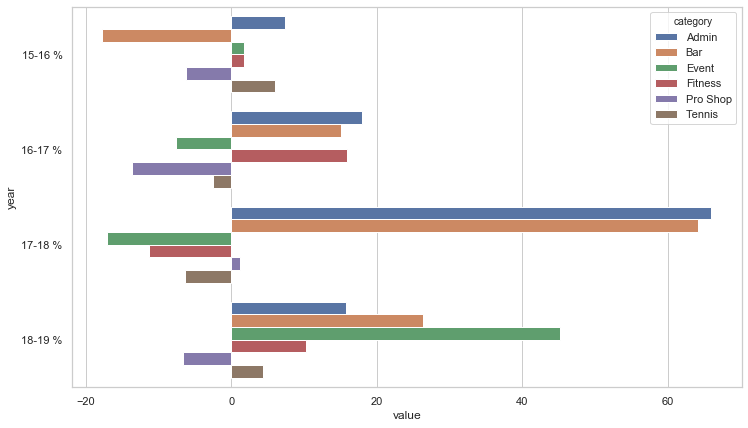

In [48]:
ypy_eng_melt = ypy_eng.melt(id_vars="category",var_name="year")
plt.figure(figsize=(12,7))
sns.barplot(x="value", y="year", hue="category",data=ypy_eng_melt[ypy_eng_melt.year.isin(["15-16 %","16-17 %","17-18 %","18-19 %"])])

## FINDING:
- Engagement in Program is volatile.
- Admin (Membership) & Bar peaked in 2018 but steadied in 2019.
- Event rose in 2019.
- Tennis and Fitness are recovering from 2018 dip.

## SEASONALITY & TREND: Breakdown

In [10]:
df_bar = dft[dft.category == "Bar"]
df_tennis = dft[dft.category == "Tennis"]
df_program = dft[dft.category == "Program"]
df_ps = dft[dft.category == "Pro Shop"]
df_admin = dft[dft.category == "Admin"]
df_event = dft[dft.category == "Event"]
df_fitness = dft[dft.category == "Fitness"]

<Figure size 1152x504 with 0 Axes>

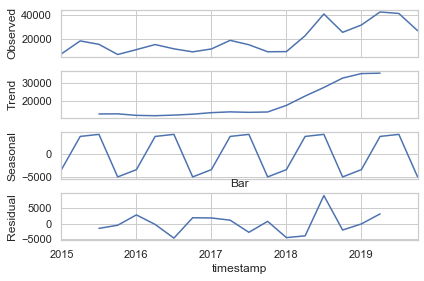

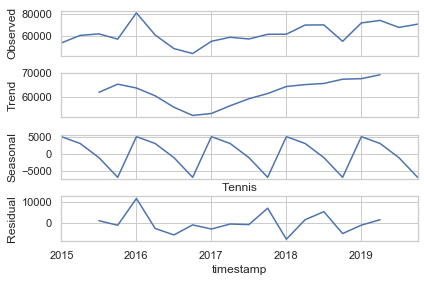

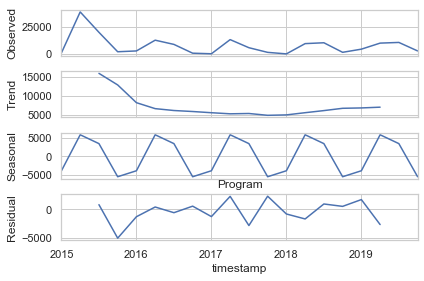

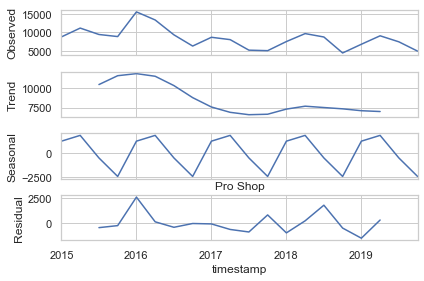

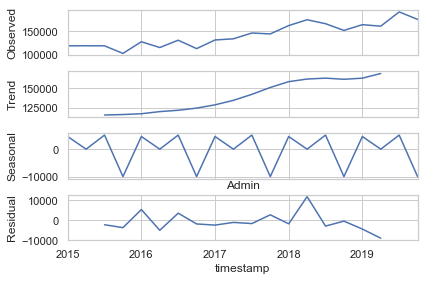

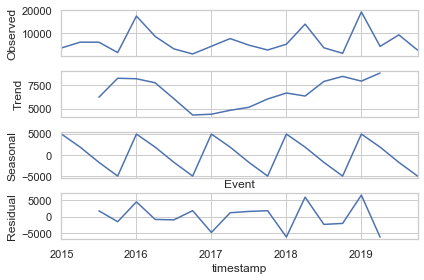

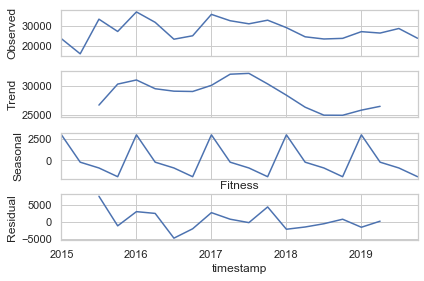

In [11]:
plt.figure(figsize=(16,7))
cat_subsets = [df_bar, df_tennis, df_program,df_ps, df_admin,df_event,df_fitness]

for i, subset in enumerate(cat_subsets):
    decomposition = sm.tsa.seasonal_decompose(subset["total"].resample('Q').sum(), model='additive')    
    fig = decomposition.plot()
    
    titles = {0:"Bar",1:"Tennis",2:"Program",3:"Pro Shop",4:"Admin",5:"Event",6:"Fitness"}
    fig.show()
    plt.title(f"{titles[i]}")

## FINDING:
- JNCC Business is **HIGHLY SEASONAL**.
- Product Lines on UPWARD Trend:
    - Bar
    - Tennis
    - Admin (Membership)
    - Event
- Product Lines on DOWNWARD Trend:
    - Program
    - Pro Shop
    - Fitness

## Month per Month Seasonality

In [12]:
mpm = pd.pivot_table(dft,values="acn",index="category",columns="month",aggfunc=np.sum)

In [13]:
mpm

month     01 January  02 February  03 March  04 April   05 May   06 June  \
category                                                                   
Admin        2160928      2022731   2154881   2135987  2391786   3160265   
Bar          5124769      4665332   6730263   7239918  9619541  11350642   
Event         580917       260519    606826    316969   659662    551180   
Fitness       845419       815074    729922    714378  1008330    656635   
Pro Shop      522070       536659    635726    781516   749053    595229   
Program         8963        15270     85926    109210   208981    523859   
Tennis       2232440      1961363   2256466   2904339  2280429   2243646   

month      07 July  08 August  09 September  10 October  11 November  \
category                                                               
Admin      3451463    3336922       3356449     3203647      3308067   
Bar       13233104   10539985       8072016     7792578      5975856   
Event       741797     476765        379179      266004       347475   
Fitness     942402     902394        858711     1028447       856399   
Pro Shop    585444     650630        642439      562204       459228   
Program     474936     129041         17221        8756        75340   
Tennis     2447980    2769603       2754216     2964779      2598075   

month     12 December  
category               
Admin         3256864  
Bar           5672317  
Event          367121  
Fitness        733532  
Pro Shop       410701  
Program         78681  
Tennis        1887009

In [14]:
mpm_melt = mpm.reset_index().rename(columns={"month":"index"})
mpm_melt = mpm_melt.melt(id_vars="category",var_name="month")

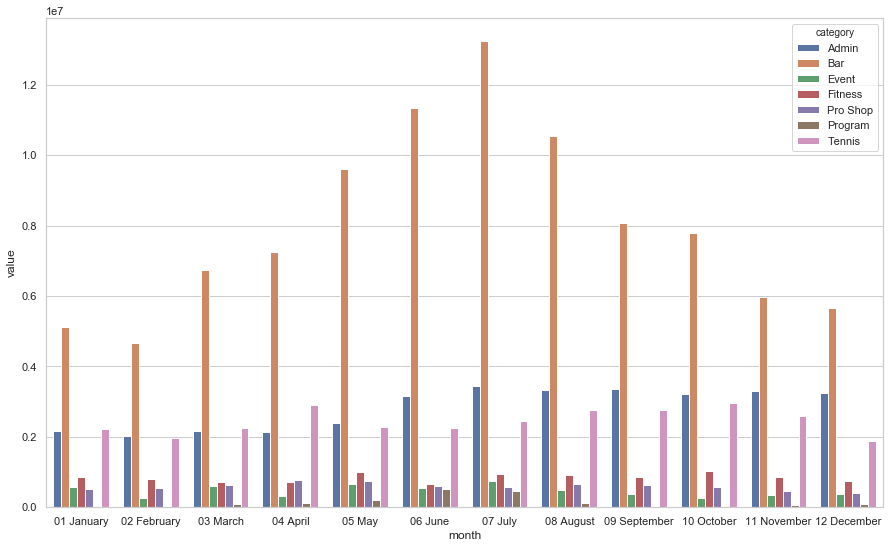

In [17]:
plt.figure(figsize=(15,9))
sns.barplot(x="month",y="value",hue="category",data=mpm_melt)

### Bar

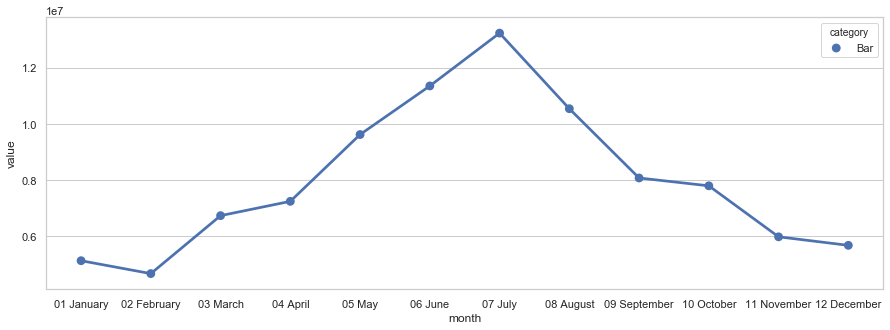

In [30]:
plt.figure(figsize=(15,5))
sns.pointplot(x="month",y="value",hue="category",data=mpm_melt[mpm_melt.category.isin(["Bar"])])

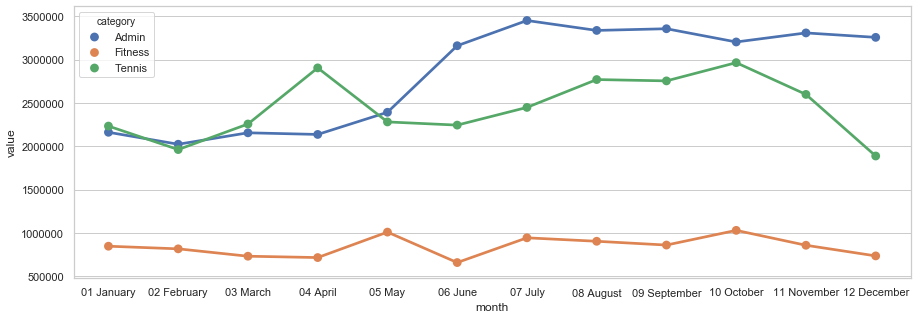

In [38]:
plt.figure(figsize=(15,5))
sns.pointplot(x="month",y="value",hue="category",data=mpm_melt[mpm_melt.category.isin(["Admin","Tennis","Fitness"])])

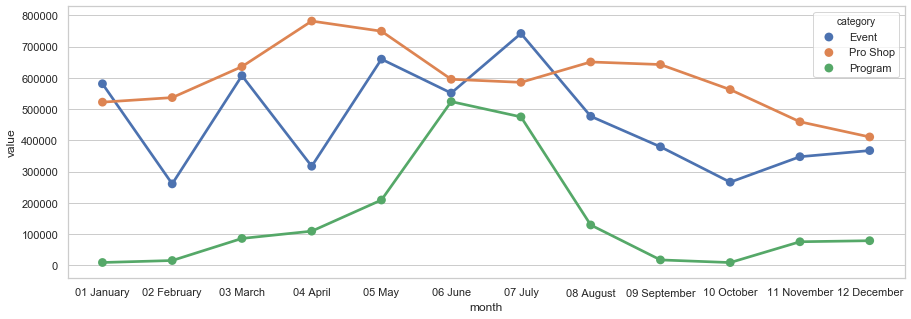

In [254]:
plt.figure(figsize=(15,5))
sns.pointplot(x="month",y="value",hue="category",data=mpm_melt[mpm_melt.category.isin(["Program","Event","Pro Shop"])])

In [258]:
peak = [{"Bar":"July", "Admin":"July-Dec","Tennis":"April & October","Fitness":"May & October","Pro Shop":"April","Program":"June & July","Events":"July"}]
off = [{"Bar":"Jan-Feb, Nov-Dec", "Admin":"Jan-April","Tennis":"Feb & Dec","Fitness":"June","Pro Shop":"November, Dec","Program":"Jan-Feb & Sept-Oct","Events":"Feb, April & Oct"}]

In [259]:
peak_seasons = pd.DataFrame(peak)
off_seasons = pd.DataFrame(off)
po_seasons = pd.concat([peak_seasons,off_seasons])
po_seasons.index = ["PEAK","OFF"]

## FINDING: Peak- and Off- Seasons Months

In [260]:
po_seasons

Admin               Bar            Events        Fitness  \
PEAK   July-Dec              July              July  May & October   
OFF   Jan-April  Jan-Feb, Nov-Dec  Feb, April & Oct           June   

           Pro Shop             Program           Tennis  
PEAK          April         June & July  April & October  
OFF   November, Dec  Jan-Feb & Sept-Oct        Feb & Dec

---

# II. What is driving sales?

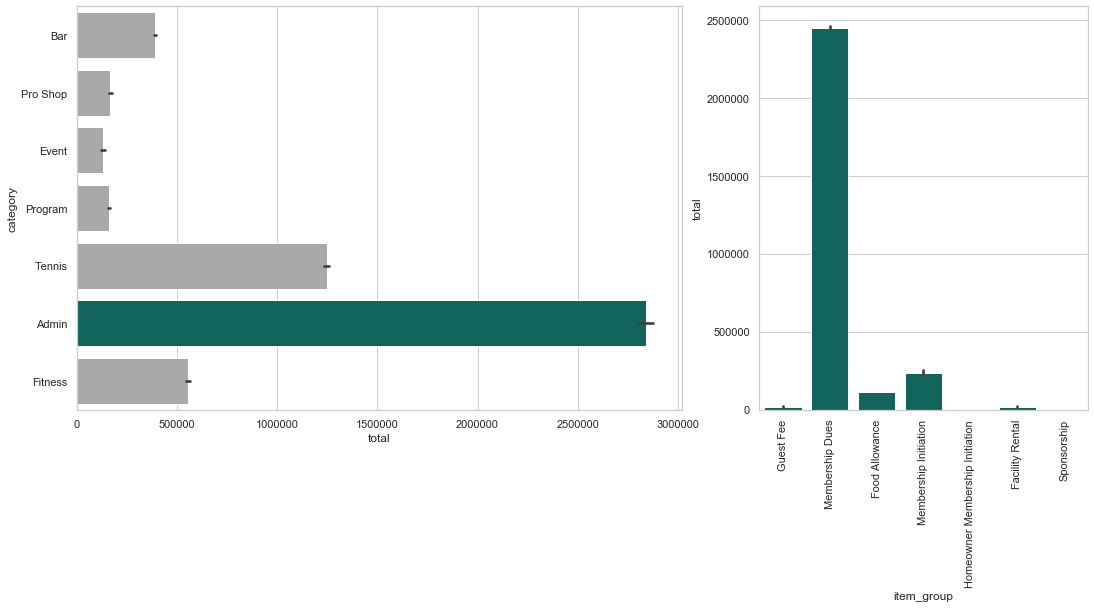

In [43]:
fig = plt.figure(figsize=(12,7))

ax1 = fig.add_axes([0.1,0.1,0.7,0.8])
ax2 = fig.add_axes([0.89,0.1,0.38,0.8])

# ax1
fig1 = sns.barplot(x="total",y="category",data=df,palette=["darkgray","darkgray","darkgray","darkgray","darkgray","#037367"],ax=ax1,estimator=sum)
# ax2
fig2 = sns.barplot(x="item_group",y="total",data=df[df.category == "Admin"],color="#037367",ax=ax2,estimator=sum)

ax2.set_xticklabels(labels=list(df[df.category == "Admin"].item_group.unique()),rotation = 90)
plt.show()

## FINDING: Membership Dues is the biggest driver of Revenue.

In [44]:
admin = dft[dft.item_group.isin(["Membership Dues","Membership Initiation"])]
admin = admin[["item_group","membership","total","month","year"]]

In [45]:
admin.head()

item_group                 membership   total         month  \
timestamp                                                                      
2018-08-31  Membership Dues  General Family Membership  149.39     08 August   
2018-07-31  Membership Dues  General Family Membership  149.39       07 July   
2018-11-30  Membership Dues  General Family Membership  149.39   11 November   
2018-12-31  Membership Dues  General Family Membership  149.39   12 December   
2018-09-30  Membership Dues  General Family Membership  149.39  09 September   

            year  
timestamp         
2018-08-31  2018  
2018-07-31  2018  
2018-11-30  2018  
2018-12-31  2018  
2018-09-30  2018

In [275]:
admin[(admin.membership.isin(["General Family Membership","General Single Membership"])) & (admin.total < 140)]

item_group                 membership   total  \
timestamp                                                                       
2018-06-22 10:42:00        Membership Dues  General Family Membership   44.82   
2019-08-22 16:50:00        Membership Dues  General Family Membership   48.19   
2019-08-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-07-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-11-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-12-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-09-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-10-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-03-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-05-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-06-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-04-30 00:00:00        Membership Dues  General Single Membership  114.20   
2016-01-19 09:30:00        Membership Dues  General Family Membership   59.02   
2019-06-10 11:53:00        Membership Dues  General Family Membership  104.57   
2015-08-31 00:00:00        Membership Dues  General Single Membership  105.54   
2015-07-31 00:00:00        Membership Dues  General Single Membership  105.54   
2015-11-30 00:00:00        Membership Dues  General Single Membership  105.54   
2015-12-31 00:00:00        Membership Dues  General Single Membership  105.54   
2015-09-30 00:00:00        Membership Dues  General Single Membership  105.54   
2015-10-31 00:00:00        Membership Dues  General Single Membership  105.54   
2017-08-31 00:00:00        Membership Dues  General Single Membership  114.20   
2017-06-30 00:00:00        Membership Dues  General Single Membership  114.20   
2017-07-31 00:00:00        Membership Dues  General Single Membership  114.20   
2017-11-30 00:00:00        Membership Dues  General Single Membership  114.20   
2017-12-31 00:00:00        Membership Dues  General Single Membership  114.20   
2017-09-30 00:00:00        Membership Dues  General Single Membership  114.20   
2017-10-31 00:00:00        Membership Dues  General Single Membership  114.20   
2017-02-28 00:00:00        Membership Dues  General Single Membership  114.20   
2017-03-31 00:00:00        Membership Dues  General Single Membership  114.20   
2017-01-31 00:00:00        Membership Dues  General Single Membership  114.20   
...                                    ...                        ...     ...   
2019-11-08 11:21:00        Membership Dues  General Family Membership  114.53   
2019-09-09 14:10:00        Membership Dues  General Single Membership   83.75   
2019-11-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-12-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-09-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-10-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-09-11 15:15:00        Membership Dues  General Family Membership   99.59   
2019-09-13 10:23:00        Membership Dues  General Single Membership   68.52   
2019-10-31 00:00:00  Membership Initiation  General Single Membership   60.00   
2019-09-16 13:38:00        Membership Dues  General Family Membership   74.69   
2019-09-17 16:28:00        Membership Dues  General Family Membership   53.29   
2019-09-17 16:28:00        Membership Dues  General Single Membership   53.29   
2019-09-19 17:02:00        Membership Dues  General Single Membership   45.68   
2019-11-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-12-31 00:00:00        Membership Dues  General Single Membership  114.20   
2019-09-30 00:00:00        Membership Dues  General Single Membership  114.20   
2019-10-31 00:00:00        Membership Dues  General Single Memb

>NOTE: Show distribution

In [46]:
admin_ypy = admin.pivot_table("total","year","item_group",aggfunc=sum)

In [47]:
admin_mpm = admin.pivot_table("total","month","item_group",aggfunc=sum)

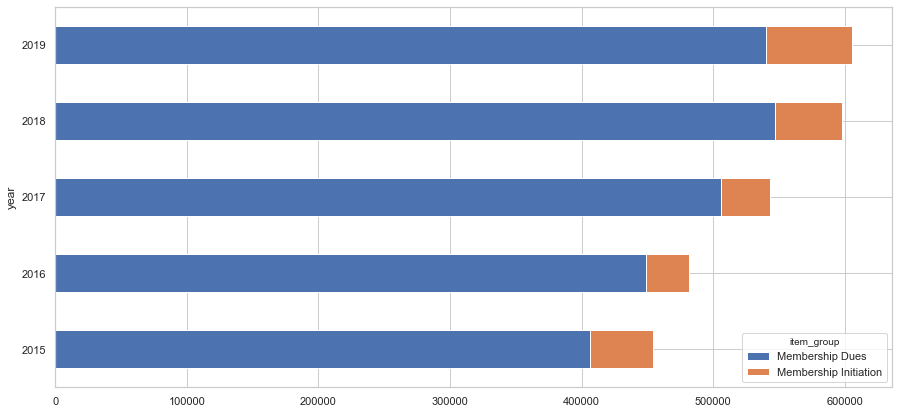

In [48]:
admin_ypy.plot(kind="barh",figsize=(15,7),stacked=True)

## FINDINGS:
 - Constant increase in Membership Dues from 2015-2018.
 - Between 2015-2019, JNCC got the most new member revenue in 2019.
 - New Member Revenue in 2018, should've fed into 2019. But 2019 Membership Dues dropped. Could be an indication of lost membership.

In [49]:
membership = dft[dft.category=="Admin"].sort_values("timestamp")

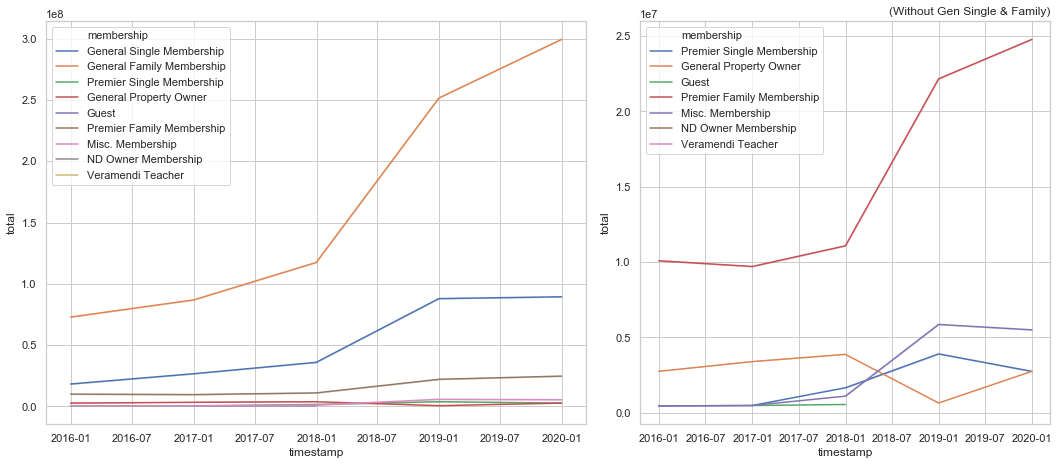

In [50]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_axes([0.1,0.1,0.5,0.8])
ax2 = fig.add_axes([0.65,0.1,0.38,0.8])

# ax1
fig1 =  sns.lineplot(x=membership.index,y=membership.total.resample("Y").sum(),hue="membership",data=membership, estimator=sum,ax=ax1)
# ax2
fig2 =  sns.lineplot(x=membership[~membership.membership.isin(["General Single Membership","General Family Membership"])].index,y=membership.total.resample("Y").sum(),hue="membership",data=membership[~membership.membership.isin(["General Single Membership","General Family Membership"])], estimator=sum,ax=ax2)

plt.title("(Without Gen Single & Family)", loc="right")
plt.show()

## FINDINGS:
 - Bulk of the revenue comes from Gen Single, Gen Family, Premier Family.
 - General Property revenue dipped between 2018-19.

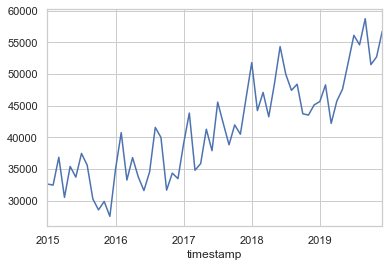

In [51]:
membership[membership.membership.isin(["General Family Membership","General Single Membership"])].total.resample("MS").sum().plot()

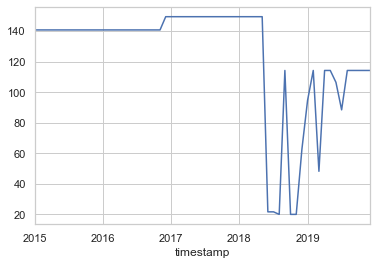

In [52]:
membership[membership.membership.isin(["General Family Membership","General Single Membership"])].total.resample("MS").median().plot()

## FINDINGS:
 - Revenue for GS and GF members dipped in late 2018 to early 2019. But trending upward.
 - Average spending for GS & GF members had been above 140, until 2018-2019 where they spend less than 120/month on average.

---

# 3. Spending Profiles

In [53]:
spend = pd.pivot_table(dft,values="total",index="acn",columns="category",aggfunc=np.sum,fill_value=0).reset_index()

In [54]:
spend.head()

category  acn    Admin      Bar    Event  Fitness  Pro Shop  Program   Tennis
0          11     0.00   801.58    80.00      0.0     95.12     90.0   208.30
1          17     0.00     9.50     0.00      0.0     10.00      0.0    30.00
2          23     0.00  1015.45     0.00      0.0     10.83      0.0  1614.26
3          33  3341.25   247.31   105.12      0.0     52.94      0.0    36.00
4          34  5231.80    14.28  2552.20      0.0      0.00      0.0     0.00

In [55]:
spend.describe()

category          acn         Admin           Bar        Event      Fitness  \
count     2725.000000   2725.000000   2725.000000  2725.000000   2725.00000   
mean      2229.111193   1041.634294    143.134697    47.514602    203.63636   
std       1454.053949   2732.954456    514.206273   210.189808   1590.60365   
min         11.000000      0.000000      0.000000     0.000000      0.00000   
25%       1069.000000      0.000000      0.000000     0.000000      0.00000   
50%       1991.000000      0.000000      7.500000     0.000000      0.00000   
75%       3274.000000     64.980000     67.370000    20.000000      0.00000   
max       5434.000000  51189.960000  11242.740000  3678.100000  31145.00000   

category     Pro Shop      Program       Tennis  
count     2725.000000  2725.000000   2725.00000  
mean        61.734628    58.731369    457.70876  
std        257.300625   215.878324   1743.57717  
min          0.000000     0.000000      0.00000  
25%          0.000000     0.000000      0.00000  
50%          0.000000     0.000000      0.00000  
75%          9.740000     0.000000    180.00000  
max       4738.440000  3865.600000  33183.90000

In [56]:
r, p = stats.pearsonr(spend["Tennis"],spend["Fitness"])
print(f"r: {r}, pval: {p}")

r: 0.4224648736290715, pval: 2.05552682732104e-118


In [57]:
r, p = stats.pearsonr(spend["Fitness"],spend["Admin"])
print(f"r: {r}, pval: {p}")

r: 0.2426298865185529, pval: 8.343311079328969e-38


In [58]:
r, p = stats.pearsonr(spend["Tennis"],spend["Admin"])
print(f"r: {r}, pval: {p}")

r: 0.28261572130150775, pval: 3.2432355345692937e-51


In [59]:
r, p = stats.pearsonr(spend["Tennis"],spend["Bar"])
print(f"r: {r}, pval: {p}")

r: 0.5288539750532986, pval: 2.99367890566669e-196


In [60]:
r, p = stats.pearsonr(spend["Fitness"],spend["Bar"])
print(f"r: {r}, pval: {p}")

r: 0.21468454471328854, pval: 8.892077990928529e-30


In [61]:
r, p = stats.pearsonr(spend["Tennis"],spend["Pro Shop"])
print(f"r: {r}, pval: {p}")

r: 0.6456797701823893, pval: 2.7e-321


In [62]:
r, p = stats.pearsonr(spend["Fitness"],spend["Pro Shop"])
print(f"r: {r}, pval: {p}")

r: 0.3219576322337395, pval: 9.312424358770584e-67


In [63]:
r, p = stats.pearsonr(spend["Tennis"],spend["Event"])
print(f"r: {r}, pval: {p}")

r: 0.5758200197391237, pval: 1.732113919415243e-240


In [64]:
r, p = stats.pearsonr(spend["Fitness"],spend["Event"])
print(f"r: {r}, pval: {p}")

r: 0.25907618894735307, pval: 4.855847304467449e-43


## Findings: Strong Positive Correlations
- Fitness & Tennis Revenue are **42%** correlated
- Tennis & Bar Revenue are **53%** correlated
- Tennis & Pro Shop Revenue are **64%** correlated
- Tennis & Event Revenue are **57%** correlated

### Spending Profile

In [130]:
spenda = pd.pivot_table(dft[dft.year.isin(["2017","2018","2019"])],values="total",index="acn",columns="category",aggfunc=np.sum,fill_value=0,margins=True).reset_index()

In [302]:
conditions = [spenda.All.between(500,2400,inclusive=True),
             spenda.All.between(2401,5999,inclusive=True),
             spenda.All.between(6000,max(spenda.All),inclusive=True),
             spenda.All.between(0-499,(spenda.All),inclusive=True)]

choices = ["1-min_spender","2-ave_spender","3-high_spender","0-dormant/inactive"]
spenda["profile"] = np.select(conditions,choices,"none")

In [298]:
spenda.tail()

category   acn       Admin        Bar     Event   Fitness  Pro Shop  Program  \
2146      5424     1200.00       0.00      0.00       0.0      0.00      0.0   
2147      5425     1506.22      27.29      0.00       0.0      0.00      0.0   
2148      5428      582.39       0.00      0.00       0.0      0.00      0.0   
2149      5434        0.00       0.00      0.00       0.0      0.00    200.0   
2150       All  1894191.56  294610.98  80738.74  338152.4  85508.85  71817.2   

category     Tennis         All             profile inclination  
2146           0.00     1200.00       1-min_spender     0-Other  
2147           0.00     1533.51       1-min_spender     0-Other  
2148           0.00      582.39       1-min_spender     0-Other  
2149           0.00      200.00  0-dormant/inactive     0-Other  
2150      776348.19  3541367.92      3-high_spender    1-Tennis

In [299]:
spenda[(spenda.profile == "3-high_spender")&(spenda.acn != "All")].All.sum()

1821489.2599999993

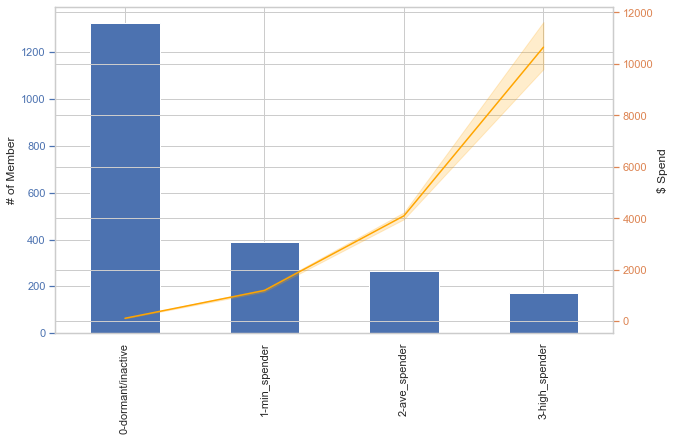

In [296]:
fig, ax = plt.subplots(figsize=(10,6))

ax = spenda.profile.value_counts(dropna=False).plot(kind="bar")

ax2 = ax.twinx()
ax2 = sns.lineplot(x=spenda.profile,y=spenda.All[spenda.acn != "All"],color="orange")

ax.set_ylabel("# of Member")
ax2.set_ylabel("$ Spend")

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

### Activity Profile

In [147]:
cond_inclination = [((spenda.Tennis == 0) & (spenda.Fitness == 0)), ((spenda.Tennis != 0) & (spenda.Tennis > spenda.Fitness)), ((spenda.Fitness != 0) & (spenda.Fitness > spenda.Tennis))]
choice_inclination = ["0-Other","1-Tennis","2-Fitness"]

spenda["inclination"] = np.select(cond_inclination,choice_inclination,0)

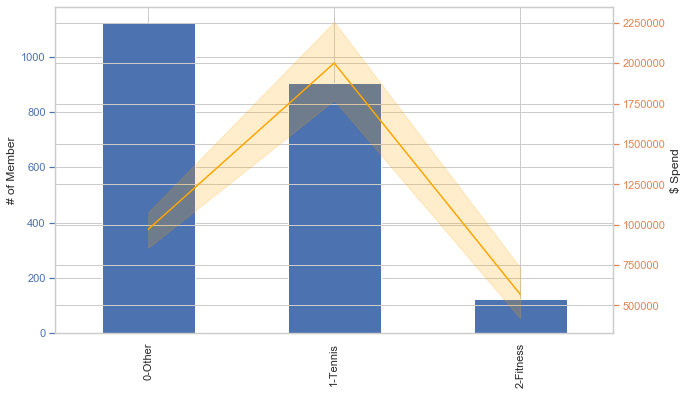

In [300]:
fig, ax = plt.subplots(figsize=(10,6))

ax = spenda.inclination.value_counts().plot(kind="bar")

ax2 = ax.twinx()
ax2 = sns.lineplot(x=spenda.inclination,y=spenda.All[spenda.acn != "All"],color="orange",estimator=sum)

ax.set_ylabel("# of Member")
ax2.set_ylabel("$ Spend")

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

plt.show()

In [304]:
spenda.tail()

category   acn       Admin        Bar     Event   Fitness  Pro Shop  Program  \
2146      5424     1200.00       0.00      0.00       0.0      0.00      0.0   
2147      5425     1506.22      27.29      0.00       0.0      0.00      0.0   
2148      5428      582.39       0.00      0.00       0.0      0.00      0.0   
2149      5434        0.00       0.00      0.00       0.0      0.00    200.0   
2150       All  1894191.56  294610.98  80738.74  338152.4  85508.85  71817.2   

category     Tennis         All             profile inclination  
2146           0.00     1200.00       1-min_spender     0-Other  
2147           0.00     1533.51       1-min_spender     0-Other  
2148           0.00      582.39       1-min_spender     0-Other  
2149           0.00      200.00  0-dormant/inactive     0-Other  
2150      776348.19  3541367.92      3-high_spender    1-Tennis

In [303]:
spenda[(spenda.inclination == "1-Tennis")&(spenda.acn != "All")].All.sum()

2001279.3099999991

In [ ]:
spenda[(spenda.inclination == "1-Tennis")&(spenda.acn != "All")].All.sum()

---

# 4. Geomapping

In [202]:
add = df[df.lat.notna() & df.long.notna()]
add = add[add.acn != 2512]
add = add.drop_duplicates("acn")

add.set_index("acn",inplace=True)
sp = spenda.set_index("acn")

In [239]:
add["mem_label"] = np.where(add.membership == "Guest", "Non-member", "Member")

In [211]:
fig = px.scatter_mapbox(add, lat="lat", lon="long", hover_name="membership",color="profile", color_discrete_sequence=["black","blue","magenta","firebrick"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [228]:
fig = px.scatter_mapbox(add, lat="lat", lon="long", hover_name="membership",color="inclination", color_discrete_sequence=["blue","slategray","firebrick"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [240]:
add.head()

trans_id            timestamp  \
acn                                   
1317     16014  2015-03-11 18:29:00   
1320    209610  2019-05-23 15:58:00   
1333    156783  2018-05-23 18:00:00   
1346     33922  2015-07-18 15:33:00   
1351     63589  2016-02-20 13:53:00   

                                                   item   item_group   total  \
acn                                                                            
1317                                       Pro Overgrip  Accessories    8.66   
1320  Summer 2019 JNCC Sports Camp | June 17th- 21st...         Camp  250.00   
1333                                             Sprite     Beverage    2.25   
1346  Pee Wee Camp 2015 | Pee Wee Session 7 | Full W...         Camp  175.00   
1351                                           Powerade     Beverage    2.75   

                     membership                      group           city  \
acn                                                                         
1317                      Guest    Founding Property Owner  NEW BRAUNFELS   
1320                      Guest     General Property Owner  NEW BRAUNFELS   
1333                      Guest  General Family Membership  NEW BRAUNFELS   
1346  General Family Membership  General Family Membership  NEW BRAUNFELS   
1351                      Guest    Founding Property Owner  NEW BRAUNFELS   

     state  zipcode  ...   Bar  Event Fitness  Pro Shop  Program   Tennis  \
acn                  ...                                                    
1317    TX  78132.0  ...  0.00   0.00     0.0      18.4      0.0   132.00   
1320    TX  78132.0  ...  8.66   0.00     0.0       0.0    500.0  1168.58   
1333    TX  78132.0  ...  8.00   0.00     0.0       0.0      0.0   489.29   
1346    TX  78130.0  ...  1.89   0.00     0.0       0.0      0.0   183.00   
1351    TX  78132.0  ...  0.00  19.49     0.0       0.0      0.0   480.00   

          All             profile  inclination   mem_label  
acn                                                         
1317   193.72  0-dormant/inactive     1-Tennis  Non-member  
1320  1677.24       1-min_spender     1-Tennis  Non-member  
1333   497.29  0-dormant/inactive     1-Tennis  Non-member  
1346   184.89  0-dormant/inactive     1-Tennis      Member  
1351   499.49  0-dormant/inactive     1-Tennis  Non-member  

[5 rows x 24 columns]

In [247]:
fig = px.scatter_mapbox(add, lat="lat", lon="long", hover_name="inclination",color="mem_label", color_discrete_sequence=["black","magenta"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [242]:
xx = pd.read_csv("cl_member.csv")

In [244]:
xx[xx.acn == 11]

Unnamed: 0  trans_id            timestamp           name  \
53              53     37777  2015-08-12 16:03:00  Cole Cantwell   
409            409     38361  2015-08-21 08:02:00  Cole Cantwell   
418            418     38360  2015-08-21 08:02:00  Cole Cantwell   
2159          2159     41019  2015-09-04 16:15:00  Cole Cantwell   
5548          5548     35130  2015-07-24 11:53:00  Cole Cantwell   
5558          5558     35131  2015-07-24 11:53:00  Cole Cantwell   
5570          5570     35132  2015-07-24 11:53:00  Cole Cantwell   
5573          5573     35139  2015-07-24 11:53:00  Cole Cantwell   
5574          5574     35138  2015-07-24 11:53:00  Cole Cantwell   
5575          5575     35137  2015-07-24 11:53:00  Cole Cantwell   
5576          5576     35136  2015-07-24 11:53:00  Cole Cantwell   
5577          5577     35135  2015-07-24 11:53:00  Cole Cantwell   
5578          5578     35134  2015-07-24 11:53:00  Cole Cantwell   
5579          5579     35133  2015-07-24 11:53:00  Cole Cantwell   
5911          5911     50650  2015-11-23 11:24:00  Cole Cantwell   
5914          5914     50622  2015-11-23 08:38:00  Cole Cantwell   
6057          6057     49262  2015-11-14 12:32:00  Cole Cantwell   
7528          7528     52993  2015-12-17 13:56:00  Cole Cantwell   
8294          8294     51773  2015-12-02 10:09:00  Cole Cantwell   
8406          8406     52556  2015-12-12 07:57:00  Cole Cantwell   
8507          8507     52704  2015-12-14 15:38:00  Cole Cantwell   
8527          8527     52803  2015-12-15 15:47:00  Cole Cantwell   
9714          9714     41838  2015-09-11 12:19:00  Cole Cantwell   
9722          9722     41839  2015-09-11 12:19:00  Cole Cantwell   
9765          9765     41721  2015-09-10 15:07:00  Cole Cantwell   
9766          9766     41720  2015-09-10 15:07:00  Cole Cantwell   
11524        11524     44946  2015-10-09 11:05:00  Cole Cantwell   
11680        11680     17456  2015-03-27 21:52:00  Cole Cantwell   
12887        12887     17047  2015-03-23 13:13:00  Cole Cantwell   
12936        12936     16691  2015-03-17 09:44:00  Cole Cantwell   
...            ...       ...                  ...            ...   
118218       18609    234610  2019-10-18 11:42:00  Cole Cantwell   
118304       18695    234467  2019-10-17 08:03:00  Cole Cantwell   
118311       18702    234474  2019-10-17 11:29:00  Cole Cantwell   
118373       18764    234813  2019-10-21 12:12:00  Cole Cantwell   
119143       19534    199385  2019-03-19 06:57:00  Cole Cantwell   
119191       19582    199397  2019-03-19 10:28:00  Cole Cantwell   
119372       19763    199081  2019-03-15 06:52:00  Cole Cantwell   
120244       20635    197636  2019-03-04 11:00:00  Cole Cantwell   
120282       20673    197690  2019-03-05 09:57:00  Cole Cantwell   
120446       20837    197945  2019-03-06 17:38:00  Cole Cantwell   
120728       21119    197483  2019-03-01 10:47:00  Cole Cantwell   
121528       21919    202505  2019-04-04 10:32:00  Cole Cantwell   
121898       22289    202388  2019-04-03 11:16:00  Cole Cantwell   
123278       23669    191514  2019-01-23 12:18:00  Cole Cantwell   
123543       23934    191178  2019-01-21 08:10:00  Cole Cantwell   
123732       24123    191299  2019-01-21 12:32:00  Cole Cantwell   
125065       25456    190656  2019-01-15 13:35:00  Cole Cantwell   
125187       25578    190797  2019-01-16 11:48:00  Cole Cantwell   
126599       26990    195869  2019-02-22 14:24:00  Cole Cantwell   
126600       26991    195870  2019-02-22 14:24:00  Cole Cantwell   
127739       28130    193505  2019-02-01 11:49:00  Cole Cantwell   
128726       29117    212308  2019-06-06 11:57:00  Cole Cantwell   
129268       29659    210163  2019-05-27 11:30:00  Cole Cantwell   
129508       29899    209510  2019-05-23 06:18:00  Cole Cantwell   
129658       30049    209724  2019-05-24 11:20:00  Cole Cantwell   
130227       30618    210509  2019-05-29 11:01:00  Cole Cantwell   
130491       30882    214634  2019-06-25 10:42:00  Cole Cantwell